In [401]:
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing, tree
from sklearn.metrics import accuracy_score, recall_score, f1_score
import seaborn as sns
from matplotlib import pyplot
from scipy import stats
import graphviz 

In [402]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
train_df.info()
train_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


(614, 13)

In [403]:
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History','Loan_Amount_Term']

numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

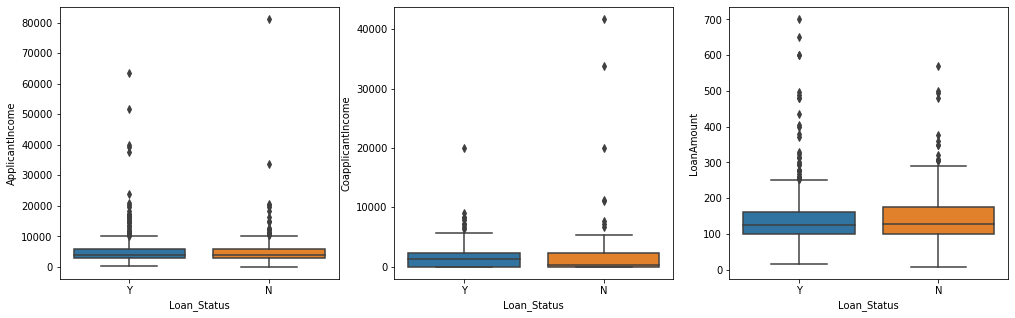

In [404]:
# visualise the nominal data
fig,axes = pyplot.subplots(1, 3, figsize=(17,5))
for idx,cat_col in enumerate(numerical_features):
    sns.boxplot(y=cat_col,data=train_df,x='Loan_Status',ax=axes[idx])

pyplot.subplots_adjust(hspace=1)

#not dropping outliers b/c ther is a lot of them and we need that data, that data is useful for the model

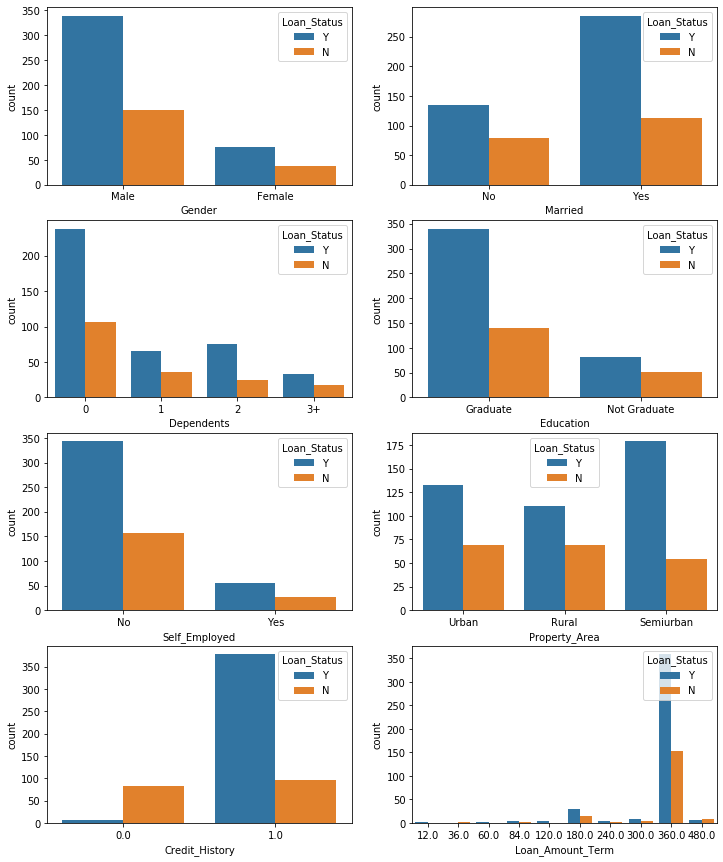

In [405]:
#visualise the relationships between the catergorical data
fig,axes = pyplot.subplots(4, 2,figsize=(12,15))
for idx,cat_col in enumerate(categorical_features):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=train_df,hue='Loan_Status',ax=axes[row,col])

In [406]:
#loan id doesn't matter so drop it
def clean_LoanID(dataset):
    dataset = dataset.drop(columns = 'Loan_ID')
    print(dataset.head())

    return dataset

train_df = clean_LoanID(train_df)
print()
test_df = clean_LoanID(test_df)

Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0   Male      No          0      Graduate            No             5849   
1   Male     Yes          1      Graduate            No             4583   
2   Male     Yes          0      Graduate           Yes             3000   
3   Male     Yes          0  Not Graduate            No             2583   
4   Male      No          0      Graduate            No             6000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0         NaN             360.0             1.0   
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   

  Property_Area Loan_Status  
0         Urban           Y  
1         Rural           N  
2         Urban           Y  
3   

In [407]:
#replace nan data with mode of the 'Married'
def clean_married(dataset):
    print(dataset['Married'].isna().sum())
    dataset['Married'].fillna(dataset['Married'].mode()[0], inplace = True)
    print(dataset['Married'].isna().sum())
    return dataset

train_df = clean_married(train_df)
print()
test_df = clean_married(test_df)


3
0

0
0


In [408]:
#replcae Nan values mode of Gender feature
def clean_gender(dataset):
    print(dataset['Gender'].isna().sum())
    inplace = dataset['Gender'].mode()[0]
    print(inplace)
    dataset['Gender'].fillna(inplace, inplace=True)
    print(dataset['Gender'].isna().sum())
    #print(dataset['Gender'].isna().sum())

    return dataset

train_df = clean_gender(train_df)
test_df = clean_gender(test_df)

13
Male
0
11
Male
0


In [409]:
#clean 'Dependents'
def clean_dependents(dataset):
    #normalize data so it is all one data type
    dataset['Dependents'] = dataset['Dependents'].replace('3+', 3)
    dataset['Dependents'] = dataset['Dependents'].replace('2', 2)
    dataset['Dependents'] = dataset['Dependents'].replace('1', 1)
    dataset['Dependents'] = dataset['Dependents'].replace('0', 0)
    print(dataset['Dependents'].loc[[7,8]])
    print(dataset['Dependents'].loc[[104, 105, 106]])
    print()
    #replace Nan values with mode of 'Dependents' feature
    dataset['Dependents'].fillna(dataset['Dependents'].mode()[0], inplace = True)

    print(dataset['Dependents'].loc[[104, 105, 106]])

    return dataset

train_df = clean_dependents(train_df)
test_df = clean_dependents(test_df)


7    3.0
8    2.0
Name: Dependents, dtype: float64
104    NaN
105    1.0
106    2.0
Name: Dependents, dtype: float64

104    0.0
105    1.0
106    2.0
Name: Dependents, dtype: float64
7    2.0
8    2.0
Name: Dependents, dtype: float64
104    0.0
105    0.0
106    0.0
Name: Dependents, dtype: float64

104    0.0
105    0.0
106    0.0
Name: Dependents, dtype: float64


In [410]:
def clean_education(dataset):
    print(dataset['Education'].isna().sum())
    dataset['Education'].fillna(dataset['Education'].mode()[0], inplace = True)
    print(dataset['Education'])
    return dataset


train_df = clean_education(train_df)
test_df = clean_education(test_df)


0
0          Graduate
1          Graduate
2          Graduate
3      Not Graduate
4          Graduate
           ...     
609        Graduate
610        Graduate
611        Graduate
612        Graduate
613        Graduate
Name: Education, Length: 614, dtype: object
0
0          Graduate
1          Graduate
2          Graduate
3          Graduate
4      Not Graduate
           ...     
362    Not Graduate
363        Graduate
364        Graduate
365        Graduate
366        Graduate
Name: Education, Length: 367, dtype: object


In [411]:
#replace nan in self employed with mode
def clean_self_employed(dataset):
    print(dataset['Self_Employed'].isna().sum())
    dataset['Self_Employed'].fillna(dataset['Self_Employed'].mode()[0], inplace = True)
    print(dataset['Self_Employed'].isna().sum())

    return dataset



train_df = clean_self_employed(train_df)
test_df = clean_self_employed(test_df)

32
0
23
0


In [412]:
#no nan values in income so no need to do anything
def clean_income(dataset):
    print(dataset['ApplicantIncome'].isna().sum())
    print()
    return dataset

train_df = clean_income(train_df)
print()
test_df = clean_income(test_df)

0


0



In [413]:
#replace nan values of coapplicant income with 0, assuming there is no coapplicant
def clean_coapp(dataset):

    dataset['CoapplicantIncome'].fillna(0, inplace = True)
    print(dataset.head)

    return dataset

train_df = clean_coapp(train_df)
test_df = clean_coapp(test_df)

<bound method NDFrame.head of      Gender Married  Dependents     Education Self_Employed  ApplicantIncome  \
0      Male      No         0.0      Graduate            No             5849   
1      Male     Yes         1.0      Graduate            No             4583   
2      Male     Yes         0.0      Graduate           Yes             3000   
3      Male     Yes         0.0  Not Graduate            No             2583   
4      Male      No         0.0      Graduate            No             6000   
..      ...     ...         ...           ...           ...              ...   
609  Female      No         0.0      Graduate            No             2900   
610    Male     Yes         3.0      Graduate            No             4106   
611    Male     Yes         1.0      Graduate            No             8072   
612    Male     Yes         2.0      Graduate            No             7583   
613  Female      No         0.0      Graduate           Yes             4583   

     Coap

In [414]:
#replace nan values in property area with mode
def clean_property(dataset):
    print(dataset['Property_Area'].isna().sum())
    dataset['Property_Area'].fillna(dataset['Self_Employed'].mode()[0], inplace = True)
    print(dataset['Property_Area'].isna().sum())


    return dataset

train_df = clean_property(train_df)
test_df = clean_property(test_df)

0
0
0
0


In [415]:
#replace nan in credit history with mode
def clean_credit(dataset):
    print(dataset['Credit_History'].isna().sum())
    mode = dataset['Credit_History'].mode()[0]
    print(mode)
    dataset['Credit_History'].fillna(dataset['Credit_History'].mode()[0], inplace = True)
    print(dataset['Credit_History'].isna().sum())
    print()
    

    return dataset

train_df = clean_credit(train_df)
print(train_df.info())
test_df = clean_credit(test_df)

50
1.0
0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
Gender               614 non-null object
Married              614 non-null object
Dependents           614 non-null float64
Education            614 non-null object
Self_Employed        614 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       614 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(5), int64(1), object(6)
memory usage: 57.7+ KB
None
29
1.0
0



In [416]:
#drop rows in loan amount that have nan values
def clean_ammount(dataset):
    print(dataset.shape)
    dataset = dataset.dropna(subset = ['LoanAmount'])
    print(dataset.shape)

    return dataset

train_df = clean_ammount(train_df)
test_df = clean_ammount(test_df)

(614, 12)
(592, 12)
(367, 11)
(362, 11)


In [417]:
#replace nan values in lean amount term with mode
def clean_term(dataset):
    dataset['Loan_Amount_Term'].fillna(dataset['Loan_Amount_Term'].mode()[0], inplace = True)
    print

    return dataset

train_df = clean_term(train_df)
test_df = clean_term(test_df)



In [418]:
# Categorical boolean mask
categorical_feature_mask = test_df.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = test_df.columns[categorical_feature_mask].tolist()



In [419]:
#normalize the categorical features
le = preprocessing.LabelEncoder()

In [420]:
#normalize the categorical features continued
def normalize(dataset):
    dataset[categorical_cols] = dataset[categorical_cols].apply(lambda col:       le.fit_transform(col))
    print(dataset[categorical_cols].head(10))
    return dataset

train_df = normalize(train_df)
test_df = normalize(test_df)

Gender  Married  Education  Self_Employed  Property_Area
1        1        1          0              0              0
2        1        1          0              1              2
3        1        1          1              0              2
4        1        0          0              0              2
5        1        1          0              1              2
6        1        1          1              0              2
7        1        1          0              0              1
8        1        1          0              0              2
9        1        1          0              0              1
10       1        1          0              0              2
   Gender  Married  Education  Self_Employed  Property_Area
0       1        1          0              0              2
1       1        1          0              0              2
2       1        1          0              0              2
3       1        1          0              0              2
4       1        0          1    

In [421]:
#check that there are no nan values left  before training
print(train_df.isna().sum())


Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [422]:
#assign sperate target feature from the dataset for training
y_train = train_df['Loan_Status']
X_train = train_df.drop(columns='Loan_Status')


In [423]:
#rename test data
X_test = test_df

In [424]:
#optimal depth and min samples in leaces
#train the decition tree model
tree_clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf = 30)
tree_clf = tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
y_score = y_train.sample(len(y_pred))

In [425]:
#score the decition tree model
print("Test F1 Score: ", f1_score(y_score,y_pred, average= 'binary', pos_label='Y'))
print('Test Recall score', recall_score(y_score,y_pred, average= 'binary', pos_label='Y'))
print('Test Accuracy score: ', accuracy_score(y_score, y_pred))

Test F1 Score:  0.7540983606557377
Test Recall score 0.8448979591836735
Test Accuracy score:  0.6270718232044199


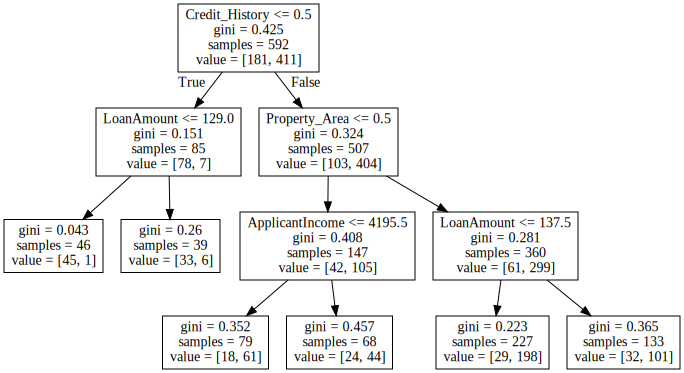

In [426]:
import graphviz
dot_data = tree.export_graphviz(tree_clf, feature_names= X_train.columns.to_list())
graph = graphviz.Source(dot_data)
graph